In [2]:
import os, math, time, random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -------- Choose dataset here --------
DATASET = "MNIST"   # "MNIST" or "CIFAR10"

# to keep EM fast; increase if you have a strong GPU
N_TRAIN = 10000
N_TEST  = 2000

# components to test
COMP_LIST = [8, 16, 32, 64, 128]

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
if DATASET.upper() == "MNIST":
    transform = transforms.ToTensor()  # [0,1], [1,28,28]
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    H, W, C = 28, 28, 1
elif DATASET.upper() == "CIFAR10":
    transform = transforms.ToTensor()  # [0,1], [3,32,32]
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    H, W, C = 32, 32, 3
else:
    raise ValueError("DATASET must be 'MNIST' or 'CIFAR10'.")

# Subsample to keep EM fast
train_idx = np.random.choice(len(train_ds), size=min(N_TRAIN, len(train_ds)), replace=False)
test_idx  = np.random.choice(len(test_ds),  size=min(N_TEST, len(test_ds)),   replace=False)
train_ds  = Subset(train_ds, train_idx)
test_ds   = Subset(test_ds,  test_idx)

def ds_to_torch(dataset, device):
    X = []
    for x, _ in dataset:
        # x: [C,H,W] in [0,1]
        x = x.view(C, H, W).permute(1,2,0).reshape(-1)  # flatten to D
        X.append(x)
    X = torch.stack(X, dim=0).to(device)  # [N, D], float32
    return X

Xtr = ds_to_torch(train_ds, device)
Xte = ds_to_torch(test_ds,  device)

Ntr, D = Xtr.shape
Nte = Xte.shape[0]
print(f"Train: {tuple(Xtr.shape)}, Test: {tuple(Xte.shape)}, Image shape: {(H,W,C)}")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.67MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 139kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 987kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.43MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Train: (10000, 784), Test: (2000, 784), Image shape: (28, 28, 1)


In [4]:
def mse_torch(a, b):
    return torch.mean((a - b) ** 2)

def batch_psnr_torch(a, b, data_range=1.0):
    # a,b in [0,1], shape [N, D]
    # compute per-image MSE then PSNR; return mean PSNR
    N = a.shape[0]
    # reshape to image tensors for clarity
    aa = a.view(N, H, W, C)
    bb = b.view(N, H, W, C)
    mse_per = torch.mean((aa - bb) ** 2, dim=(1,2,3))
    # avoid log(0)
    eps = 1e-12
    ps = 10.0 * torch.log10((data_range ** 2) / torch.clamp(mse_per, min=eps))
    return ps.mean().item()

def show_grid(images_np, titles=None, ncols=8, vmax=1.0):
    n = len(images_np)
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(1.5*ncols, 1.5*nrows))
    for i, im in enumerate(images_np):
        plt.subplot(nrows, ncols, i+1)
        if C == 1:
            plt.imshow(im.reshape(H, W), cmap="gray", vmin=0, vmax=vmax)
        else:
            plt.imshow(im.reshape(H, W, C))
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()

def to_cpu_np(x):
    return x.detach().to("cpu").numpy()


In [5]:
@torch.no_grad()
def pca_reconstruct_torch(X, n_components):
    """
    PCA via torch.linalg.svd (economy) on centered data.
    X: [N,D] on device
    returns X_hat [N,D], and a dict with components, mean, etc.
    """
    mu = X.mean(dim=0, keepdim=True)          # [1,D]
    Xc = X - mu                                # [N,D]
    # economy SVD: Xc = U S Vh; Vh shape [D,D], but we can request full_matrices=False
    U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
    # take top-k
    Vh_k = Vh[:n_components, :]                # [k,D]
    S_k  = S[:n_components]                    # [k]
    U_k  = U[:, :n_components]                 # [N,k]
    # low-rank reconstruction: Xc_hat = U_k @ diag(S_k) @ Vh_k
    Xc_hat = (U_k * S_k) @ Vh_k                # broadcasting diag
    X_hat = Xc_hat + mu
    model = {"mu": mu, "Vh_k": Vh_k, "S_k": S_k}
    return X_hat, model

print("Sanity PCA:", pca_reconstruct_torch(Xtr[:512], 32)[0].shape)


Sanity PCA: torch.Size([512, 784])


In [6]:
class PPCA_Torch:
    """
    Probabilistic PCA via EM in Torch.
    X on device (float32) in [0,1], shape [N,D]
    """
    def __init__(self, n_components, tol=1e-5, max_iter=200, verbose=False, device=None):
        self.k = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.verbose = verbose
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.W = None
        self.mu = None
        self.sigma2 = None

    @torch.no_grad()
    def fit(self, X):
        X = X.to(self.device)
        N, D = X.shape
        self.mu = X.mean(dim=0)                # [D]
        Xc = X - self.mu                       # [N,D]

        # init via PCA (Torch SVD)
        U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
        Vh_k = Vh[:self.k, :]                              # [k,D]
        # PCA loadings scaled by sqrt(eigvals)
        # eigvals of covariance ~ (S^2 / (N-1)), use S for scale
        W = (Vh_k.T * (S[:self.k] / math.sqrt(max(N-1,1e-6)))).contiguous()  # [D,k]

        # noise variance init as avg leftover variance
        if self.k < min(N, D):
            eigvals = (S**2) / max(N-1,1e-6)
            sigma2 = torch.mean(eigvals[self.k:]).clamp(min=1e-6)
        else:
            sigma2 = torch.tensor(1e-6, device=self.device)

        Iq = torch.eye(self.k, device=self.device)
        prev_ll = -float("inf")

        for it in range(self.max_iter):
            # E-step
            # M = W^T W + sigma^2 I
            M = W.T @ W + sigma2 * Iq                           # [k,k]
            # Ez = (Xc W) M^{-1}; solve M * Ez^T = (Xc W)^T
            XW = Xc @ W                                         # [N,k]
            Ez = torch.linalg.solve(M, XW.T).T                  # [N,k]
            # E[zz^T] sum = N*sigma^2 M^{-1} + Ez^T Ez
            Minv = torch.linalg.inv(M)
            Ezz_sum = N * sigma2 * Minv + Ez.T @ Ez             # [k,k]

            # M-step
            # W_new = Xc^T Ez (Ezz_sum)^{-1}
            W_new = torch.linalg.solve(Ezz_sum.T, (Xc.T @ Ez).T).T  # [D,k] via (A B^{-1})^T trick

            # sigma^2 update
            term1 = torch.sum(Xc * Xc)
            term2 = 2.0 * torch.trace(W_new.T @ (Xc.T @ Ez))
            term3 = torch.trace((W_new.T @ W_new) @ Ezz_sum)
            sigma2_new = (term1 - term2 + term3) / (N * D)
            sigma2_new = torch.clamp(sigma2_new, min=1e-8)

            # log-likelihood (optional)
            C = W_new @ W_new.T + sigma2_new * torch.eye(D, device=self.device)
            # slogdet more stable on GPU
            sign, logdet = torch.linalg.slogdet(C)
            if sign <= 0:
                ll = -float("inf")
            else:
                invC = torch.linalg.inv(C)
                ll = -0.5 * (N * (logdet + D * math.log(2*math.pi)) + torch.sum((Xc @ invC) * Xc))

            if self.verbose and (it % 10 == 0):
                print(f"[EM {it:3d}] ll={ll.item():.3f} sigma2={sigma2_new.item():.6f}")

            if abs(ll.item() - prev_ll) < self.tol:
                W, sigma2 = W_new, sigma2_new
                break

            W, sigma2 = W_new, sigma2_new


In [10]:
class PPCA_Torch:
    """
    Probabilistic PCA via EM in Torch.
    X on device (float32) in [0,1], shape [N,D]
    """
    def __init__(self, n_components, tol=1e-5, max_iter=200, verbose=False, device=None):
        self.k = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.verbose = verbose
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.W = None
        self.mu = None
        self.sigma2 = None

    @torch.no_grad()
    def fit(self, X):
        X = X.to(self.device)
        N, D = X.shape
        self.mu = X.mean(dim=0)                # [D]
        Xc = X - self.mu                       # [N,D]

        # init via PCA (Torch SVD)
        U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
        Vh_k = Vh[:self.k, :]                              # [k,D]
        # PCA loadings scaled by sqrt(eigvals)
        # eigvals of covariance ~ (S^2 / (N-1)), use S for scale
        W = (Vh_k.T * (S[:self.k] / math.sqrt(max(N-1,1e-6)))).contiguous()  # [D,k]

        # noise variance init as avg leftover variance
        if self.k < min(N, D):
            eigvals = (S**2) / max(N-1,1e-6)
            sigma2 = torch.mean(eigvals[self.k:]).clamp(min=1e-6)
        else:
            sigma2 = torch.tensor(1e-6, device=self.device)

        Iq = torch.eye(self.k, device=self.device)
        prev_ll = -float("inf")

        for it in range(self.max_iter):
            # E-step
            # M = W^T W + sigma^2 I
            M = W.T @ W + sigma2 * Iq                           # [k,k]
            # Ez = (Xc W) M^{-1}; solve M * Ez^T = (Xc W)^T
            XW = Xc @ W                                         # [N,k]
            Ez = torch.linalg.solve(M, XW.T).T                  # [N,k]
            # E[zz^T] sum = N*sigma^2 M^{-1} + Ez^T Ez
            Minv = torch.linalg.inv(M)
            Ezz_sum = N * sigma2 * Minv + Ez.T @ Ez             # [k,k]

            # M-step
            # W_new = Xc^T Ez (Ezz_sum)^{-1}
            W_new = torch.linalg.solve(Ezz_sum.T, (Xc.T @ Ez).T).T  # [D,k] via (A B^{-1})^T trick

            # sigma^2 update
            term1 = torch.sum(Xc * Xc)
            term2 = 2.0 * torch.trace(W_new.T @ (Xc.T @ Ez))
            term3 = torch.trace((W_new.T @ W_new) @ Ezz_sum)
            sigma2_new = (term1 - term2 + term3) / (N * D)
            sigma2_new = torch.clamp(sigma2_new, min=1e-8)

            # log-likelihood (optional)
            C = W_new @ W_new.T + sigma2_new * torch.eye(D, device=self.device)
            # slogdet more stable on GPU
            sign, logdet = torch.linalg.slogdet(C)
            if sign <= 0:
                ll = -float("inf")
            else:
                invC = torch.linalg.inv(C)
                ll = -0.5 * (N * (logdet + D * math.log(2*math.pi)) + torch.sum((Xc @ invC) * Xc))

            if self.verbose and (it % 10 == 0):
                print(f"[EM {it:3d}] ll={ll.item():.3f} sigma2={sigma2_new.item():.6f}")

            if abs(ll.item() - prev_ll) < self.tol:
                W, sigma2 = W_new, sigma2_new
                break

            W, sigma2 = W_new, sigma2_new
            prev_ll = ll.item()

        self.W = W
        self.sigma2 = sigma2
        return self

    @torch.no_grad()
    def transform(self, X):
        X = X.to(self.device)
        Xc = X - self.mu
        M = self.W.T @ self.W + self.sigma2 * torch.eye(self.k, device=self.device)
        XW = Xc @ self.W
        Ez = torch.linalg.solve(M, XW.T).T
        return Ez

    @torch.no_grad()
    def inverse_transform(self, Z):
        return Z @ self.W.T + self.mu


k=64 | PCA:  MSE=0.009227,  PSNR=21.40 dB,  time=0.37s
k=64 | PPCA: MSE=0.009255,  PSNR=21.29 dB,  time=0.27s
Original


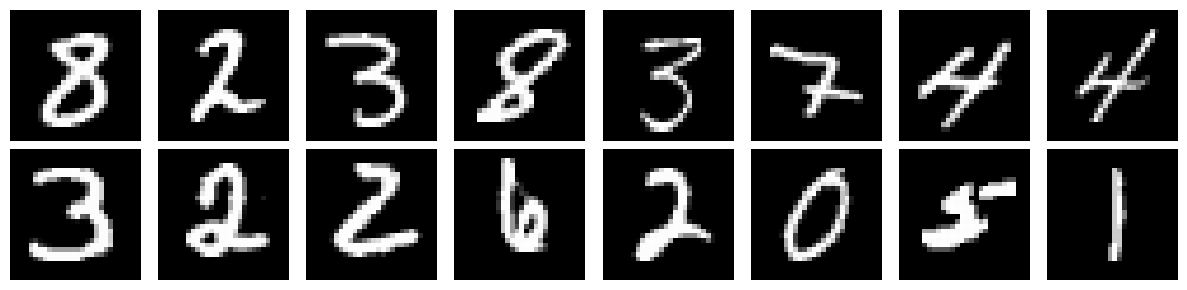

PCA recon


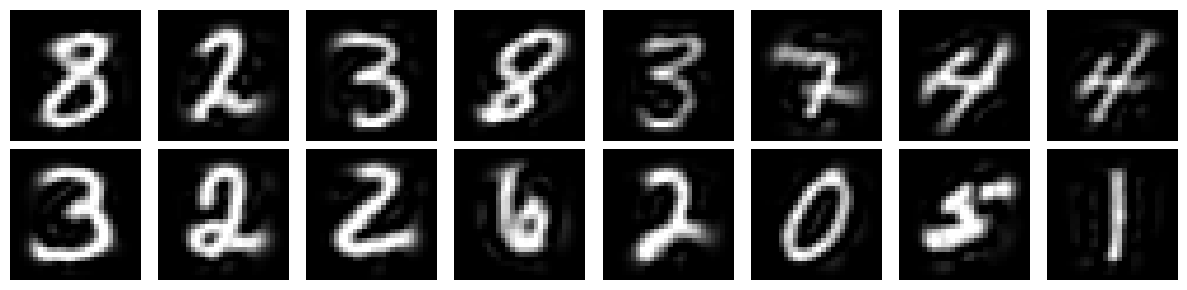

PPCA recon


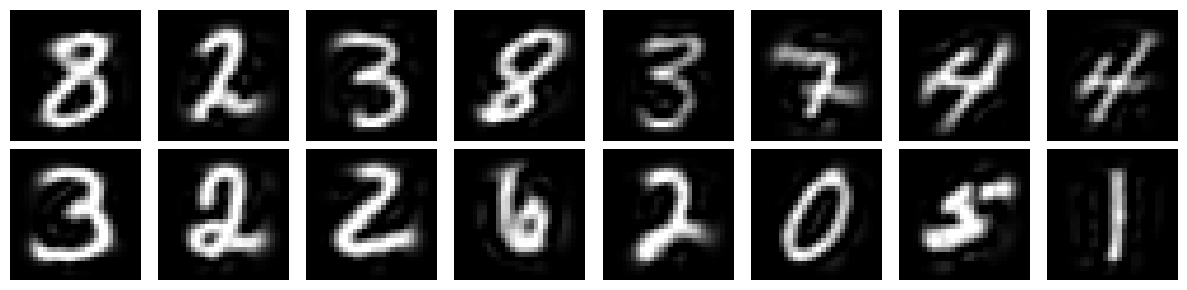

In [11]:
k = 64  # try 32/64/128 depending on GPU memory

# ---- PCA (Torch) ----
t0 = time.time()
Xh_pca, pca_state = pca_reconstruct_torch(Xtr, n_components=k)
pca_time = time.time() - t0

# ---- PPCA (Torch EM) ----
ppca = PPCA_Torch(n_components=k, max_iter=200, tol=1e-5, verbose=False, device=device)
t0 = time.time()
ppca.fit(Xtr)
Ez_tr = ppca.transform(Xtr)
Xh_ppca = ppca.inverse_transform(Ez_tr)
ppca_time = time.time() - t0

# Metrics on TRAIN recon (apples-to-apples)
mse_pca  = mse_torch(Xtr, Xh_pca).item()
mse_ppca = mse_torch(Xtr, Xh_ppca).item()
psnr_pca  = batch_psnr_torch(Xtr, torch.clamp(Xh_pca, 0, 1))
psnr_ppca = batch_psnr_torch(Xtr, torch.clamp(Xh_ppca, 0, 1))

print(f"k={k} | PCA:  MSE={mse_pca:.6f},  PSNR={psnr_pca:.2f} dB,  time={pca_time:.2f}s")
print(f"k={k} | PPCA: MSE={mse_ppca:.6f},  PSNR={psnr_ppca:.2f} dB,  time={ppca_time:.2f}s")

# Visualize a few reconstructions
nshow = 16
idx = torch.randperm(Ntr, device=device)[:nshow]

orig = Xtr[idx]
rec_pca = torch.clamp(Xh_pca[idx],  0, 1)
rec_ppc = torch.clamp(Xh_ppca[idx], 0, 1)

print("Original")
show_grid(to_cpu_np(orig), ncols=8)
print("PCA recon")
show_grid(to_cpu_np(rec_pca), ncols=8)
print("PPCA recon")
show_grid(to_cpu_np(rec_ppc), ncols=8)


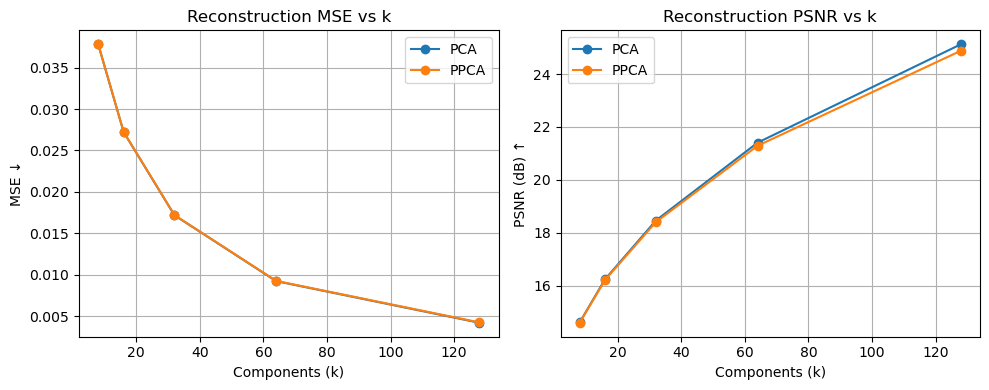

Timing (seconds) per method:
k=  8 | PCA   0.37s | PPCA   0.22s
k= 16 | PCA   0.08s | PPCA   0.11s
k= 32 | PCA   0.08s | PPCA   0.22s
k= 64 | PCA   0.08s | PPCA   0.23s
k=128 | PCA   0.08s | PPCA   0.31s


In [12]:
results = {"k":[], "mse_pca":[], "psnr_pca":[], "mse_ppca":[], "psnr_ppca":[], "t_pca":[], "t_ppca":[]}

for k in COMP_LIST:
    # PCA
    t0 = time.time()
    Xh_pca, _ = pca_reconstruct_torch(Xtr, n_components=k)
    t_pca = time.time() - t0

    # PPCA
    ppca = PPCA_Torch(n_components=k, max_iter=200, tol=1e-5, verbose=False, device=device)
    t0 = time.time()
    ppca.fit(Xtr)
    Ez = ppca.transform(Xtr)
    Xh_ppca = ppca.inverse_transform(Ez)
    t_ppca = time.time() - t0

    # metrics
    m_pca  = mse_torch(Xtr, Xh_pca).item()
    p_pca  = batch_psnr_torch(Xtr, torch.clamp(Xh_pca, 0,1))
    m_ppca = mse_torch(Xtr, Xh_ppca).item()
    p_ppca = batch_psnr_torch(Xtr, torch.clamp(Xh_ppca,0,1))

    results["k"].append(k)
    results["mse_pca"].append(m_pca)
    results["psnr_pca"].append(p_pca)
    results["mse_ppca"].append(m_ppca)
    results["psnr_ppca"].append(p_ppca)
    results["t_pca"].append(t_pca)
    results["t_ppca"].append(t_ppca)

# Plot
ks = results["k"]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, results["mse_pca"],  marker="o", label="PCA")
plt.plot(ks, results["mse_ppca"], marker="o", label="PPCA")
plt.xlabel("Components (k)")
plt.ylabel("MSE ↓")
plt.title("Reconstruction MSE vs k")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ks, results["psnr_pca"],  marker="o", label="PCA")
plt.plot(ks, results["psnr_ppca"], marker="o", label="PPCA")
plt.xlabel("Components (k)")
plt.ylabel("PSNR (dB) ↑")
plt.title("Reconstruction PSNR vs k")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

print("Timing (seconds) per method:")
for i,k in enumerate(ks):
    print(f"k={k:3d} | PCA {results['t_pca'][i]:6.2f}s | PPCA {results['t_ppca'][i]:6.2f}s")


TEST MSE/PSNR
  PCA : 0.009133204817771912 21.46319580078125
  PPCA: 0.009160959161818027 21.34563446044922
Test originals


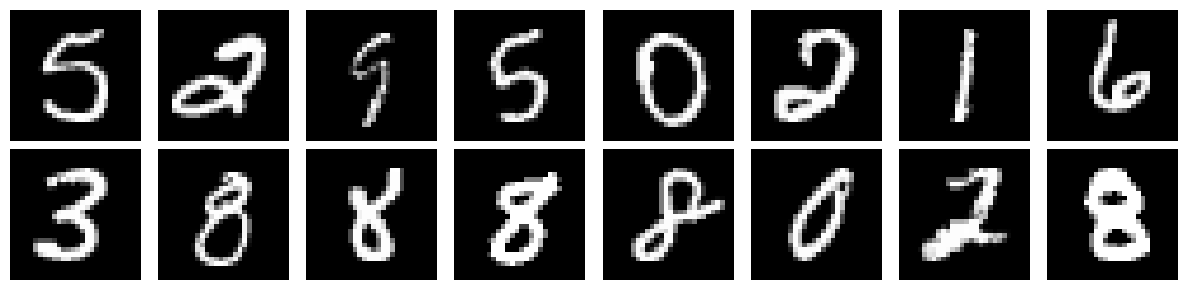

Test PCA recon


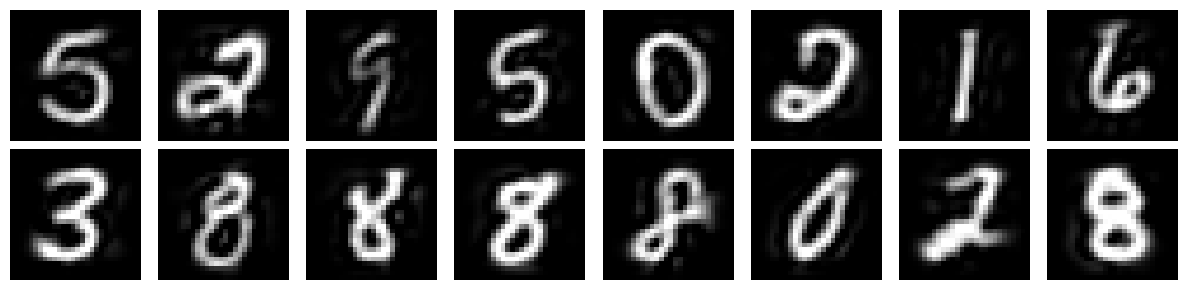

Test PPCA recon


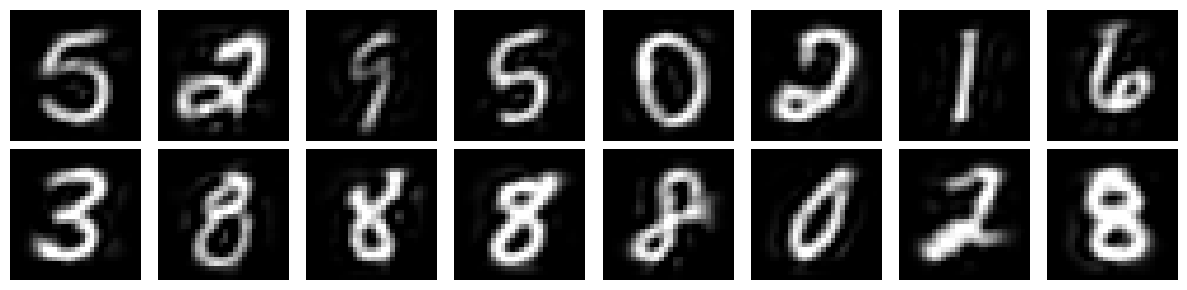

In [13]:
@torch.no_grad()
def reconstruct_with_pca_state(X, state):
    # X: [N,D], state from pca_reconstruct_torch
    mu   = state["mu"]
    Vh_k = state["Vh_k"]
    S_k  = state["S_k"]

    Xc = X - mu
    # projection Z = Xc V_k (where V_k = Vh_k^T)
    V_k = Vh_k.T
    Z   = Xc @ V_k
    # inverse transform: Xc_hat = Z V_k^T (same as low-rank proj)
    Xc_hat = Z @ V_k.T
    return Xc_hat + mu

k = 64

# Fit PCA once for state (re-do SVD)
_, pca_state = pca_reconstruct_torch(Xtr, n_components=k)

# Fit PPCA
ppca = PPCA_Torch(n_components=k, max_iter=200, tol=1e-5, verbose=False, device=device).fit(Xtr)

# Reconstruct TEST
Xte_pca  = reconstruct_with_pca_state(Xte, pca_state)
Ez_te    = ppca.transform(Xte)
Xte_ppca = ppca.inverse_transform(Ez_te)

print("TEST MSE/PSNR")
print("  PCA :", mse_torch(Xte, Xte_pca).item(),  batch_psnr_torch(Xte, torch.clamp(Xte_pca,0,1)))
print("  PPCA:", mse_torch(Xte, Xte_ppca).item(), batch_psnr_torch(Xte, torch.clamp(Xte_ppca,0,1)))

# Visualize a few
idx = torch.randperm(Nte, device=device)[:16]
print("Test originals")
show_grid(to_cpu_np(Xte[idx]), ncols=8)
print("Test PCA recon")
show_grid(to_cpu_np(torch.clamp(Xte_pca[idx],0,1)), ncols=8)
print("Test PPCA recon")
show_grid(to_cpu_np(torch.clamp(Xte_ppca[idx],0,1)), ncols=8)
